<a href="https://www.rhyme.com"> <img src="https://www.rhyme.com/assets/img/logo-dark.png" alt="Header" style="width: 100px;"/> </a>
<h1 align=center> Image Super Resolution using Autoencoders</h1>

<img src="images/high_res_v_low_res.jpg" width=550px>

## Task 1: Project Overview and Import Libraries

In [1]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

2.1.0


## Task 2: What are Autoencoders?

<img src="images/autoencoder.jpg">
Credit: Autoencoder Schema by <a href="https://blog.keras.io/img/ae/autoencoder_schema.jpg">Francois Chollet, 2016</a>.

<h4 align=center>Encoder Architecture</h4>
<img src="images/encoder.png" width=450px align=center>

## Task 3: Build the Encoder

In [2]:
# Input Layer 
input_img = Input(shape=(256, 256, 3))

# First CNN Layer/ Layer_1 64 filters, with 3x3 kernal size with zero padding 
# Using relu activation function and l1 regularizer to the output layer 
l1 = Conv2D(64, (3, 3), padding="same", activation="relu",
            activity_regularizer=regularizers.l1(10e-10))(input_img)

# Second CNN Layer with same paramters of l1
l2 = Conv2D(64, (3, 3), padding="same", activation="relu",
            activity_regularizer=regularizers.l1(10e-10))(l1)

# Down-scale the image by scale factor of two using MaxPlooling2D
l3 = MaxPooling2D(padding="same")(l2)

# More CNN to learn new features in new and smaller space

# CNN with 128 filters to learn more fetures, & every thing else remain the same as the previous cnn
# Increasing the number of filters to 128 
# Because the space is smaller, so we have less information 
# So, more convolutions to try to compensate the loss of the information
l4 = Conv2D(128, (3, 3), padding="same", activation="relu",
            activity_regularizer=regularizers.l1(10e-10))(l3)

l5 = Conv2D(128, (3, 3), padding="same", activation="relu",
            activity_regularizer=regularizers.l1(10e-10))(l4)

# Descent and get closer to the space where we find our encoded representation
l6 = MaxPooling2D(padding="same")(l5)

# Final cnn with more filters 
l7 = Conv2D(256, (3, 3), padding="same", activation="relu",
            activity_regularizer=regularizers.l1(10e-10))(l6)

# Create Encoder model 
encoder = Model(input_img, l7)

In [3]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0     

## Task 4: Build the Decoder to Complete the Network

<img src="images/decoder.png" width=450px>

In [4]:
input_img = Input(shape=(256, 256, 3))

l1 = Conv2D(64, (3, 3), padding="same", activation="relu",
            activity_regularizer=regularizers.l1(10e-10))(input_img)

l2 = Conv2D(64, (3, 3), padding="same", activation="relu",
            activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding="same")(l2)


l4 = Conv2D(128, (3, 3), padding="same", activation="relu",
            activity_regularizer=regularizers.l1(10e-10))(l3)

l5 = Conv2D(128, (3, 3), padding="same", activation="relu",
            activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding="same")(l5)

l7 = Conv2D(256, (3, 3), padding="same", activation="relu",
            activity_regularizer=regularizers.l1(10e-10))(l6)



In [5]:
# Upsampling Layer for upsampling compressed reprsentaion of img from l7 
l8 = UpSampling2D()(l7)

# Find more features from recoverd image with Conv-filters using cnn
l9 = Conv2D(128, (3, 3), padding="same", activation="relu",
          activity_regularizer=regularizers.l1(10e-10))(l8)

l10 = Conv2D(128, (3, 3), padding="same", activation="relu",
          activity_regularizer=regularizers.l1(10e-10))(l9)

# Merge layer/ Skip Connection 
# 1- To share knowldge from Encoder to Decoder 
# 2- Help network not lossing information by going deeper (Residual connection) for Vanishing Gradient Problem 
l11 = add([l5, l10])

# Upsampling Again
l12 = UpSampling2D()(l11)

l13 = Conv2D(64, (3, 3), padding="same", activation="relu",
          activity_regularizer=regularizers.l1(10e-10))(l12)

l14 = Conv2D(64, (3, 3), padding="same", activation="relu",
          activity_regularizer=regularizers.l1(10e-10))(l13)

# Second Skip Connection 
l15 = add([l14, l2])

# final output layer (decoded image) same number of channels as oroginal img 3 channels 
decoded =  Conv2D(3, (3, 3), padding="same", activation="relu",
          activity_regularizer=regularizers.l1(10e-10))(l15)

# Create Auto-Encoder 
autoencoder = Model(input_img, decoded)

# Show Auto-encoder Summary
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_6[0][0]                   
____________________________________________________________________________________________

In [7]:
# Compile Auto-Encoder
autoencoder.compile(optimizer="adadelta", loss="mean_squared_error")

## Task 5: Create Dataset and Specify Training Routine

In [6]:
def train_batches(just_load_dataset=False):
    
    # Number of images 
    batches = 256 
    
    # Number of images in the current batch  
    batch = 0 
    
    # Current Index of the batch 
    batch_nb = 0 
    
    max_batches = -1 
    
    # Number of epocs
    ep = 4 
    
    images = []
    
    # List of High Resolution images
    x_train_n = []
    
    # List of Low Resolution images 
    x_train_down = []
    
    x_train_n2 = [] 
    
    # Store lS images of dataset
    x_train_down2 = []
    
    for root, dirnames, filenames in os.walk("/home/rhyme/Desktop/Project/data/cars_train"):
        for filename in filenames:
            
            # For reading different formats of the images 
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                
                # Read image
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                    
                    # Resize images to 256x256
                    image_resized = resize(image, (256, 256))
                    
                    # Append HR img to HR list
                    x_train_n.append(image_resized)
                    
                    # Append LR img to LR list 
                    x_train_down.append(rescale(rescale(image_resized, 0.5), 2.0))
                    
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        # False mean just return the 2 array of HR and LR images 
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

## Task 6: Load the Dataset and Pre-trained Model

In [8]:
# Create x_train_n for High resolution images, and x_train_down for low Resolution images 
# We will use the pre-trained model of the previous model
# So, Just load the data using train_batches method 
x_train_n, x_train_down = train_batches(just_load_dataset=True)

/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [13]:
# Use the pre-trained model of the previous Auto-Encoder model
autoencoder.load_weights('/home/rhyme/Desktop/Project/data/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5')

## Task 7: Model Predictions and Visualizing the Results

In [15]:
# Viewing Model Representaion (Encoder output )
# Load Encoder weight 
encoder.load_weights('/home/rhyme/Desktop/Project/data/encoder_weights.hdf5')

In [16]:
# Get the Encoded images 
# Feed the Encoder the input images 
encoded_imgs = encoder.predict(x_train_down)

In [17]:
# Print the shape of encoded_imgs array
encoded_imgs.shape

(256, 64, 64, 256)

encoded_imgs containes a representation of each image (256 images)<br>
each represenation is in 3 dimensions 64x64x256

In [19]:
# limit the values of array to be only between [0, 1] to clip the oytput to not preduce eired colors
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0) 

In [20]:
# Plot SL images 
# Choose image indeeeeeeeeeeeee
image_index = np.random.randint(0, 256)

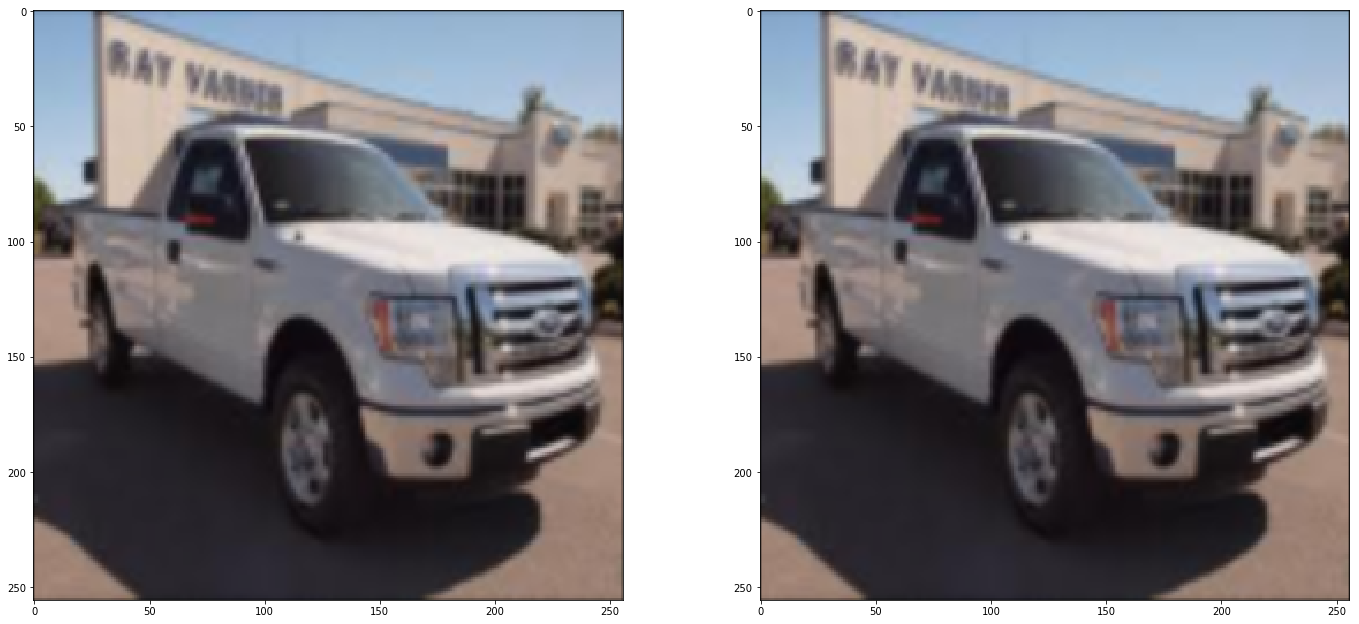

In [22]:
plt.figure(figsize=(128, 128))
i= 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])

i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])

i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])